<a href="https://colab.research.google.com/github/alexandraeremia06/Kaggle/blob/main/Predict_Greenweez_Churners_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 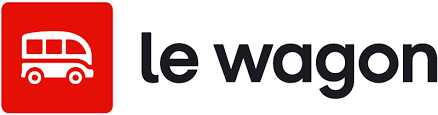

# Predict Greenweez Churners


In this challenge were are going to look at the Greenweez client database!

We want to find out who amongst our existing database of clients will reconvert 🔁 (ie. make a second purchase) within 3 months.

**Our data**

➡️ We have access to the sales from 2019 to 2021.

➡️ Let's take a look


## Data exploration


a) Execute the cell below to load our client data into a dataframe variable called `df`.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


# pandas for data manipulation.
# numpy for numerical operations.
# matplotlib.pyplot for plotting.
# seaborn for enhanced data visualization.
# sklearn.model_selection for splitting data into training and test sets.
# sklearn.preprocessing for data scaling (e.g., StandardScaler).
# sklearn.linear_model for machine learning models (e.g., LogisticRegression).
# sklearn.metrics for evaluating model performance (e.g., accuracy_score, ConfusionMatrixDisplay).

In [8]:
from google.colab import auth
import pandas as pd

# Will collect your credentials
auth.authenticate_user()

# Query Bigquery
query = "SELECT * FROM `data-analytics-bootcamp-363212.course33.gwz_churn`"
project = "data-analytics-bootcamp-363212"

df = pd.read_gbq(query=query, project_id=project)

/tmp/ipython-input-2748969520.py:11: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=query, project_id=project)


b) Let's take a look at our data.

1. As usual, it's useful to first look at the first few rows.
2. What's the shape of our data?
3. Are there any null values?  
4. Given that we are trying to predict 'reconversions', what is our target?

In [11]:
# 1
df.head()

,date_date,orders_id,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
0,2021-03-08,797405,207754,3,65.456667,196.37,29.333333,88,0,23.000000,1,0
1,2021-06-23,914331,229390,2,84.650000,169.30,40.000000,80,0,34.500000,1,0
2,2021-04-27,857750,4921,3,48.343333,145.03,20.000000,60,0,11.666667,1,1
3,2021-02-28,786589,10797,8,74.970000,599.76,26.500000,212,0,20.750000,8,1
4,2021-06-08,901782,116681,3,62.113333,186.34,16.666667,50,0,9.333333,1,0


In [12]:
#2
df.shape

(381398, 12)

In [13]:
#3
df.isnull().sum()
# no null values in the DataFrame

,0
date_date,0
orders_id,0
customers_id,0
nb_past_orders,0
avg_basket,0
total_purchase_cost,0
avg_quantity,0
total_quantity,0
nb_days_since_last_order,0
avg_nb_unique_products,0


In [14]:
#4
df['re_purchase'].value_counts()
# 0 as not re_purchase and 1 as re_purchase

,count
re_purchase,
0,199523
1,181875


c) What do you think of column `orders_id` for our problem? Is it useful for our analysis?

orders_id is not useful in this case! It is the unique identifier for the Greenweez database, but doesn't provide any info that we use to predict reconversions (same with date_date)

d) Now, delete `orders_id` and `date_date` columns.

In [15]:
# deleting a column: df.drop(['orders_id','date_date'])
df.drop(['orders_id', 'date_date'], axis=1, inplace=True)

e) Have a look at whether our columns values are on different scales. To do this, use the DataFrame `.describe()` method to compare them.

What kind of preprocessing we will have to use ?

In [16]:
# DataFrame.describe()
pd.DataFrame.describe(df)

# normalization technique for transforming the values on the same scale

,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
count,381398.0,381398.0,381398.000000,381398.000000,381398.000000,381398.0,381398.0,381398.000000,381398.0,381398.0
mean,161066.560242,2.058692,51.570302,124.525402,13.558555,33.825301,0.0,8.392141,0.544751,0.476864
std,95853.282456,2.030991,41.144718,291.427518,13.202761,71.181359,0.0,7.364444,1.441715,0.499465
min,2.0,1.0,0.000000,0.000000,1.000000,1.0,0.0,1.000000,0.0,0.0
25%,69762.0,1.0,26.290000,30.310000,5.500000,7.0,0.0,3.000000,0.0,0.0
50%,174880.0,1.0,43.760000,65.550000,10.333333,16.0,0.0,6.500000,0.0,0.0
75%,244394.0,2.0,66.840000,150.350000,18.000000,38.0,0.0,11.500000,1.0,1.0
max,314334.0,61.0,4726.440000,22738.110000,1480.000000,3557.0,0.0,163.000000,57.0,1.0


It seems that the features are indeed on different scales, so we will need to use a normalization technique (example, total_nb_codes in comparison with avg_basket).



f) Set column `customers_id` as index to keep customer_id information.

In [17]:
df.set_index('customers_id', inplace=True)

Note that for the sake of the exercise, we've **already preprocessed some of the data for you** 🔧.

This means you'll be working on a (relatively) clean database, with your targets and features already formed. In a real-world situation, it's likely that you'll be spending a lot of time forming your target and features from simpler, less-specific data, either using python or SQL to manipulate the database.

## Modeling

Now that we've seen what our data looks like, we need to define our target and features.

a) Split dataset into a train and a test set (this should give you an `X_train`, `X_test`, `y_train` and `y_test`).

We will keep a test_size of 20%.

In [19]:
X = df.drop('re_purchase', axis=1)
y = df['re_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
test_customers_ids = X_test.index

b) Execute the cell below to apply normalization on our data. We are going to use a StandardScaler for this transformation.

*Make sure you understand what this code does.*

Why do we use `.fit_transform()` on the train set and `.transform()` on the test set?

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# apply same transformation on X_test
X_test = scaler.transform(X_test)

c) What are the types of X_train and X_test?

In [25]:
type(X_train)

numpy.ndarray

In [26]:
type(X_test)

numpy.ndarray

d) Before building our first model we need a baseline to compare our futur models!

For this example, calculate the accuracy score for a stupid model returning always 1.

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score

baseline_y_pred = pd.Series(np.ones([76280]))

baseline_accuracy = accuracy_score(y_test, baseline_y_pred)

print(f"Baseline accuracy is {round(baseline_accuracy,2)}")

Baseline accuracy is 0.48


Now that we have a baseline, even if it's poor, we will try to surpass it!

e) Let's build our first model!

We will use a simple logistic regression model. Execute cell below to train your model on the train data and store the test data predictions in a variable `y_pred`.

Make sure you understand what this code does.

In [30]:
from sklearn.linear_model import LogisticRegression

# train model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# store predictions
y_pred = clf.predict(X_test)

f) Calculate the accuracy you get on test data.

How do you interpret this value?

In [31]:
# accuracy_score from sklearn.metrics, comparing the true test labels (y_test) with the model's predictions (y_pred)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

Accuracy on test data: 0.73


logistic regression score corresponds to accuracy (it shows how often the model made the right guess). in our case, 73% accuracy on the train and test dataset shows that 73% out of 100% were good predictions. moreover, there seems to be no case of overfitting here as the model's performance (accuracy) is almost the same on both the data it learned from and the new data. this means it hasn't overfit or just memorizing traning examples, rather it's learning general patterns.

g) Accuracy is one way to judge model performance, but plotting a confusion matrix on the test data can be more informative. This is because you can calculate additional metrics from this matrix!

Execute cell below to plot confusion matrix.

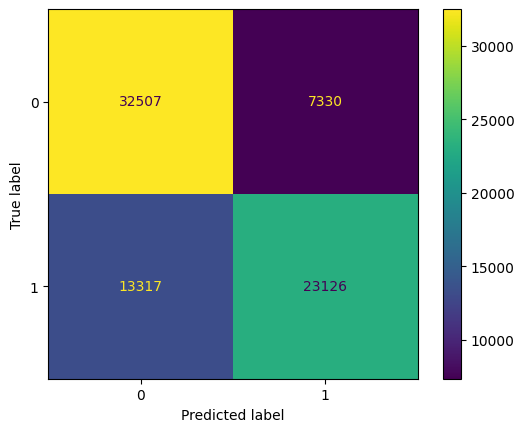

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

h) From your confusion matrix and the below picture, calculate:
- precision
- recall
- accuracy

Remember to make sure you are using the values associated with the correct labels when doing so!

# from the confusion matrix: 32507, 7330, 13317, 23126 (from top-left to bottom-right, row by row), these values typically correspond to:

True Negatives (TN): 32507 (Top-Left: Correctly predicted '0' - did not re-purchase)
False Positives (FP): 7330 (Top-Right: Incorrectly predicted '1' - said they would re-purchase, but they didn't)
False Negatives (FN): 13317 (Bottom-Left: Incorrectly predicted '0' - said they would not re-purchase, but they did)
True Positives (TP): 23126 (Bottom-Right: Correctly predicted '1' - did re-purchase)
The Total number of samples is the sum of all these: 32507 + 7330 + 13317 + 23126 = 76280.

# calculating each metric:

Precision (for class 1: 're-purchase')

formula: True Positives / (True Positives + False Positives)
calculation: 23126 / (23126 + 7330)
23126 / 30456 = 0.759397...
result: approximately 75.94%
interpretation: when the model predicts a customer will re-purchase, it is correct about 75.94% of the time.


Recall (for class 1: 're-purchase')

formula: True Positives / (True Positives + False Negatives)
calculation: 23126 / (23126 + 13317)
23126 / 36443 = 0.634563...
result: approximately 63.46%
interpretation: the model correctly identifies 63.46% of all customers who actually re-purchase.

Accuracy

formula: (True Positives + True Negatives) / Total Samples
calculation: (23126 + 32507) / 76280
55633 / 76280 = 0.729352...
result: approximately 72.94%
interpretation: the model correctly predicts the outcome (either re-purchase or not re-purchase) for 72.94% of all customers.

In [33]:
# precision: Precision: this metric answers, "of all the instances our model predicted as positive, how many were actually positive?"
# it's particularly useful when the cost of false positives is high
# formula: True Positives / (True Positives + False Positives)

from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

Precision: 0.76


In [34]:
# recall (sensitivity): this metric answers, "Of all the actual positive instances, how many did our model correctly identify?"
# it's important when the cost of false negatives is high
# formula: True Positives / (True Positives + False Negatives)

from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.63


In [35]:
# accuracy: this is the most straightforward metric and tells you the proportion of total predictions that were correct
# formula: (True Positives + True Negatives) / (True Positives + True Negatives + False Positives + False Negatives)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


![confusion matrix](https://wagon-public-assets.s3.eu-west-3.amazonaws.com/pchl73lhb84nyh6ic4yzw98bl2me)

- precision: 23126 / (23126 + 7330)
23126 / 30456 = 0.759397...
result: approximately 75.94%
- recall: 23126 / (23126 + 13317) 23126 / 36443 = 0.634563... result: approximately 63.46%
- accuracy: (23126 + 32507) / 76280 55633 / 76280 = 0.729352... result: approximately 72.94%


i) What is the percent of churners your model correctly detected? Is it good?

number_churners_correctly_detected / number_of_churners = 32719 / (32719 + 7269) = 32504 / 39988 = 81.82%

I think it is not bad at all, we have now a model to identify 81.82% of churners

j) What does the code below do? Why would this be useful from a business perspective?

In [36]:
proba = pd.DataFrame(clf.predict_proba(X_test), columns=["Churner", "Not churner"], index=test_customers_ids)
proba

,Churner,Not churner
customers_id,,
155491,0.717983,0.282017
128947,0.522608,0.477392
182161,0.493472,0.506528
264456,0.529564,0.470436
203492,0.482830,0.517170
...,...,...
267743,0.800469,0.199531
21678,0.733965,0.266035
32425,0.188806,0.811194


we can get probability to repurchase or not (column not churner).


k) Filter this dataframe on customers who have between 20% and 50% probability to re purchase.

Customers with a probability of less than 20% to repurchase are considered lost.

In [37]:
filtered_proba = proba[(proba['Not churner'] >= 0.20) & (proba['Not churner'] <= 0.50)]
print(f"Number of customers with 20-50% probability to re-purchase: {len(filtered_proba)}")
filtered_proba.head()

Number of customers with 20-50% probability to re-purchase: 44820


,Churner,Not churner
customers_id,,
155491,0.717983,0.282017
128947,0.522608,0.477392
264456,0.529564,0.470436
275712,0.779376,0.220624
296458,0.745197,0.254803


l) Well done! You now have a model that predicts churners.

Using this model, suggest a process that can be implemented at GreenWeez to help the company reduce the churn rate.


I think that we can predict possible churners on a regular basis, data that could be sent to the CRM so they can target those specific users by offering discounts, coupons etc. hoping this will help the retain rate
